# Twitter Bot or Not? 

    ~~~~ Write a nice intro here

In [1]:
# Basics
import pandas as pd
import psycopg2 as pg
import numpy as np
import pickle

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from visualize import *
from model_evaluation import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model support
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

## Data import and set up

In [2]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',             # Connecting to _local_ version of psql
    'dbname': 'twitter_accounts',    # DB with Twitter info
    'port': 5432                     # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [3]:
raw_df = pd.read_sql('SELECT * FROM human_bots', connection)

In [4]:
# drop funny index column
raw_df.drop(columns=['index'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [5]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'acct_location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days']]

In [6]:
del raw_df

In [7]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_favorites'] = np.round(df['followers_count'] / df['account_age_days'])

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible popularity metrics
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['statuses_count']) / np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3) ## Changed this from * to /
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

In [9]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [10]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

## Basic model evaluation

In [10]:
# Models that require scaling: 
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

model_list = [knn, lr]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [11]:
multi_model_eval(model_list, X_train_scaled, y, kf)

Model: KNeighborsClassifier(n_neighbors=10)
------------------------------
Accuracy:  0.83767 +- 0.004042
Precision: 0.80131 +- 0.006912
Recall:    0.68362 +- 0.013989
F1 Score:  0.73768 +- 0.006909
ROC AUC:   0.89569 +- 0.003649

Model: LogisticRegression()
------------------------------
Accuracy:  0.80314 +- 0.002075
Precision: 0.71114 +- 0.006977
Recall:    0.69157 +- 0.010010
F1 Score:  0.70113 +- 0.003798
ROC AUC:   0.85181 +- 0.002741



In [12]:
# Models that don't require scaling
gnb = gnb = GaussianNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

model_list = [gnb, tree, forest, xgb]
kf = KFold(n_splits=3, shuffle=True, random_state=33)

In [13]:
multi_model_eval(model_list, X, y, kf)

Model: GaussianNB()
------------------------------
Accuracy:  0.69503 +- 0.059328
Precision: 0.55385 +- 0.090251
Recall:    0.82332 +- 0.138664
F1 Score:  0.64431 +- 0.011958
ROC AUC:   0.82068 +- 0.002617

Model: DecisionTreeClassifier()
------------------------------
Accuracy:  0.80939 +- 0.002353
Precision: 0.71024 +- 0.000315
Recall:    0.72512 +- 0.005673
F1 Score:  0.71759 +- 0.002855
ROC AUC:   0.78837 +- 0.002933

Model: RandomForestClassifier()
------------------------------
Accuracy:  0.86770 +- 0.001160
Precision: 0.84300 +- 0.008357
Recall:    0.74226 +- 0.007224
F1 Score:  0.78936 +- 0.000730
ROC AUC:   0.92475 +- 0.002663

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints

RandomForest and XGBoost seem most promising. 

Will look at ROC Curve for each next. 

Average AUC Score: 0.9262 +- 0.003707


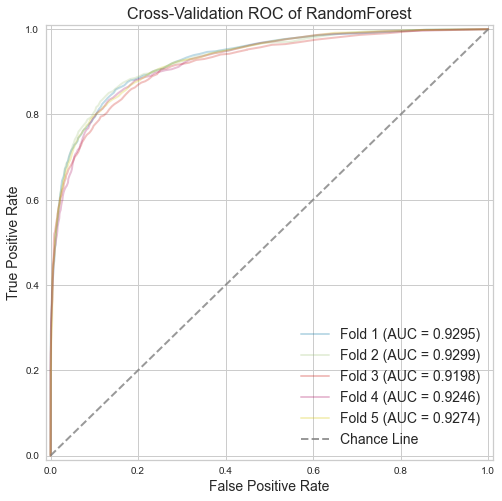

In [14]:
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average AUC Score: 0.9274 +- 0.004188


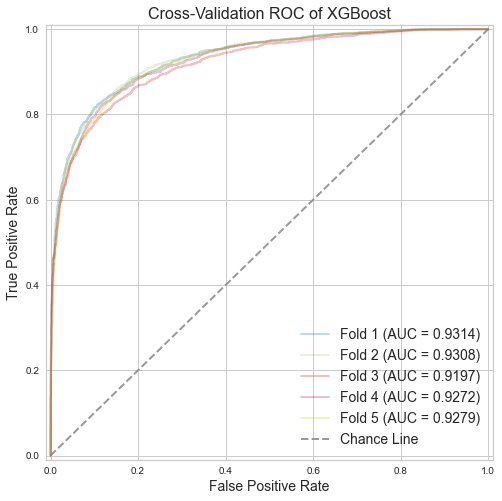

In [15]:
xgb = XGBClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

## Class weight balancing

In [14]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print(f'Bots / Total %: {(num_bots / len(df))*100:.2f}')

Number of bots:  12425
Number of humans:  25013
Bots / Total %: 33.19


In [15]:
# For XGBoost
estimate = num_humans/num_bots
estimate

2.013118712273642

In [12]:
forest = RandomForestClassifier(class_weight='balanced')
xgb = XGBClassifier(scale_pos_weight=estimate)

models = [forest, xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [13]:
multi_model_eval(models, X, y, kf)

Model: RandomForestClassifier(class_weight='balanced')
------------------------------
Accuracy:  0.87018 +- 0.004783
Precision: 0.85509 +- 0.013145
Recall:    0.73602 +- 0.009215
F1 Score:  0.79104 +- 0.008936
ROC AUC:   0.92671 +- 0.003607

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.013118712273642,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
------------------------------
Accuracy:  0.86419 +- 0.004125
Precision: 0.78824 +- 0.009188
Recall:    0.81124 +- 0.007807
F1 Score:  0.79

XGBoost stands out as the clear winner here.

Let's look at a confusion matrix.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

In [15]:
xgb = XGBClassifier(scale_pos_weight=estimate)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8611
Precision: 0.7780
Recall:    0.8035
F1 Score:  0.7905

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4415
           1       0.78      0.80      0.79      2137

    accuracy                           0.86      6552
   macro avg       0.84      0.85      0.84      6552
weighted avg       0.86      0.86      0.86      6552




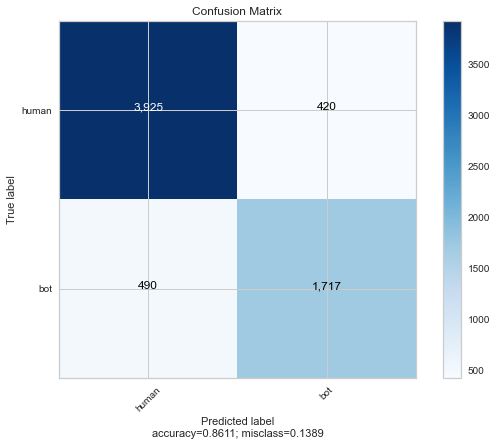

In [16]:
metrics_report(preds, y_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8622
Precision: 0.7830
Recall:    0.7988
F1 Score:  0.7908

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4415
           1       0.78      0.80      0.79      2137

    accuracy                           0.86      6552
   macro avg       0.84      0.85      0.84      6552
weighted avg       0.86      0.86      0.86      6552




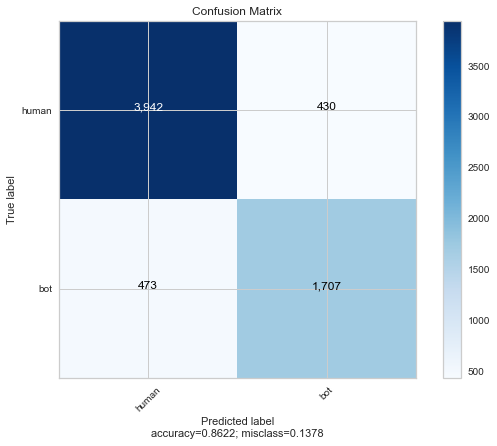

In [17]:
xgb = XGBClassifier(scale_pos_weight=estimate, 
                   tree_method='approx')

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

metrics_report(preds, y_val)

In [18]:
xgb = XGBClassifier(scale_pos_weight=estimate, 
                   tree_method='approx')

model_list = [xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.013118712273642,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)
------------------------------
Accuracy:  0.86247 +- 0.003590
Precision: 0.78491 +- 0.010179
Recall:    0.81021 +- 0.003662
F1 Score:  0.79733 +- 0.006251
ROC AUC:   0.92652 +- 0.003742



Average AUC Score: 0.9265 +- 0.003742


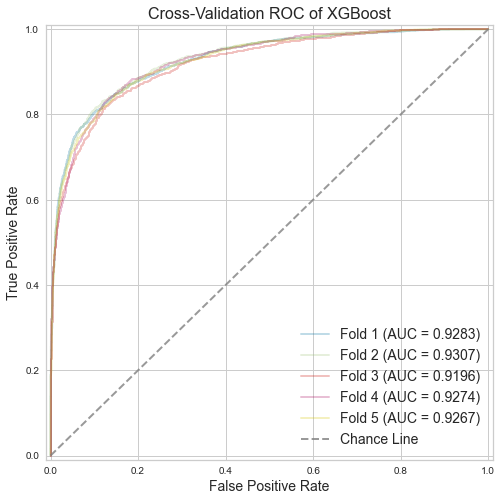

In [19]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

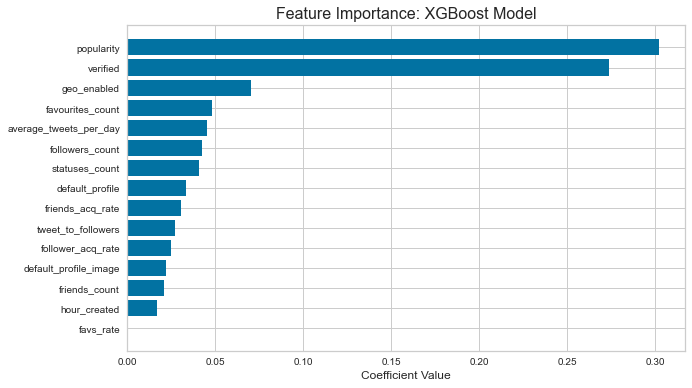

In [20]:
# set up feature_importance
importance = xgb.feature_importances_
feature_importance = list(zip(features, importance))

feature_importance.sort(key = lambda x: x[1])

# split sorted features_importance into x,y
feat = [f[0] for f in feature_importance]
imp = [i[1] for i in feature_importance]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance: XGBoost Model', fontsize=16)
plt.barh(feat, imp)
plt.xlabel('Coefficient Value', fontsize=12);

## Features

In [8]:
features = ['verified', 
            #'created_at',
            'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            #'favs_rate'
           ]

X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

In [9]:
#xgb = XGBClassifier()
xgb = XGBClassifier(scale_pos_weight=1.8, 
                    #tree_method='approx', 
                    #learning_rate=0.2           # .2
                    #eta=0.01,                    # .01
                    #max_depth=6,                 # 6 or 7 -- 7 balances pre/rec 
                    gamma=0.05
                   )

model_list = [xgb]

In [12]:
# xgb.fit(X_train, y_train)
# preds = xgb.predict(X_val)

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
------------------------------
Accuracy:  0.86652 +- 0.007523
Precision: 0.79926 +- 0.015569
Recall:    0.80157 +- 0.010375
F1 Score:  0.80038 +- 0.012339
ROC AUC:   0.92853 +- 0.004825



**Best model**
```
xgb = XGBClassifier(scale_pos_weight=1.9, 
                   tree_method='approx',
                   learning_rate=0.2,           # .2
                   eta=0.01,                    # .01
                   max_depth=6,                 # 6 or 7 -- 7 balances pre/rec 
                   gamma=0.05,
                   )
```
**Best model output**
```
------------------------------
Accuracy:  0.86446 +- 0.004792
Precision: 0.78941 +- 0.010198
Recall:    0.81018 +- 0.009043
F1 Score:  0.79964 +- 0.008638
ROC AUC:   0.92911 +- 0.003438
```

**Another great model**
```
xgb = XGBClassifier(scale_pos_weight=1.8,
                    gamma=0.05
                   )
```
**Output**
```
------------------------------
Accuracy:  0.86652 +- 0.007523
Precision: 0.79926 +- 0.015569
Recall:    0.80157 +- 0.010375
F1 Score:  0.80038 +- 0.012339
ROC AUC:   0.92853 +- 0.004825
```


Average AUC Score: 0.9285 +- 0.004825


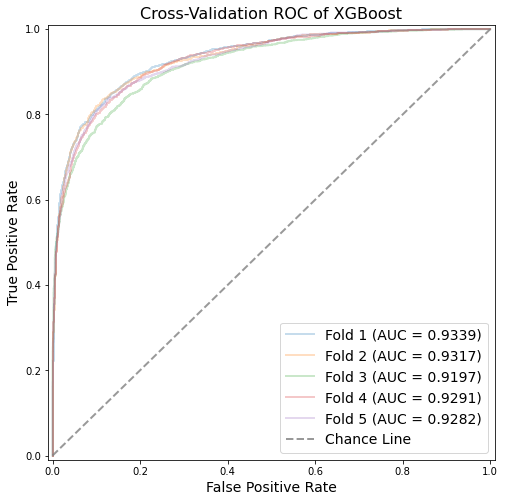

In [11]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

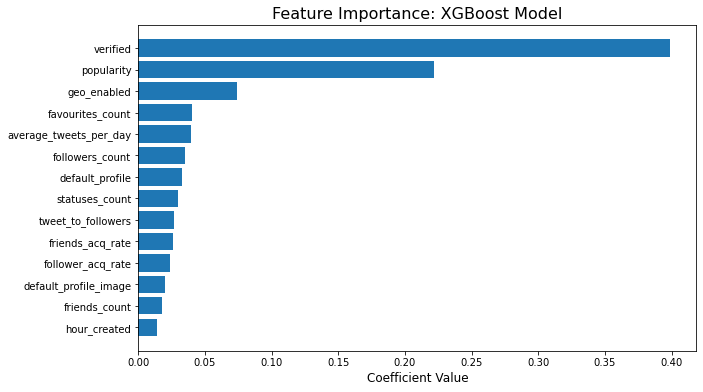

In [12]:
# set up feature_importance
importance = xgb.feature_importances_
feature_importance = list(zip(features, importance))

feature_importance.sort(key = lambda x: x[1])

# split sorted features_importance into x,y
feat = [f[0] for f in feature_importance]
imp = [i[1] for i in feature_importance]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance: XGBoost Model', fontsize=16)
plt.barh(feat, imp)
plt.xlabel('Coefficient Value', fontsize=12);

In [13]:
# Full train & test
best_model = XGBClassifier(scale_pos_weight=1.8, gamma=0.05)

In [15]:
best_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
best_model_prediction = best_model.predict(X_test)

print(f'Accuracy:  {accuracy_score(y_test, best_model_prediction):5f}')
print(f'Precision: {precision_score(y_test, best_model_prediction):5f}')
print(f'Recall:    {recall_score(y_test, best_model_prediction):5f}')
print(f'F1 Score:  {f1_score(y_test, best_model_prediction):5f}')
print(f'ROC AUC:   {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]):5f}')

Accuracy:  0.873486
Precision: 0.803832
Recall:    0.811054
F1 Score:  0.807426
ROC AUC:   0.931604


**Full train & test results!**
```
Accuracy:  0.873486
Precision: 0.803832
Recall:    0.811054
F1 Score:  0.807426
ROC AUC:   0.931604
```